In [1]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

import math
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

from torch_geometric.utils import to_dense_adj, stochastic_blockmodel_graph, erdos_renyi_graph

from models.LASE_unshared_normalized import LASE
from models.GCN import GCN
from models.RDPG_GD import RDPG_GD_Armijo, coordinate_descent
from models.SVD_truncate import embed_scipy
from training.get_init import get_x_init
from models.SVD_truncate import align_Xs

# Load the config file
with open('../data/data_config.json', 'r') as file:
    config = json.load(file)


# SBM-2 mixed

In [2]:
torch.manual_seed(42)


gd_steps = 5
device = 'cpu'
num_nodes = 1000

dataset = 'sbm2_unbalanced_positive_mixed'

d = config[dataset]['d']
p1 = config['sbm2_unbalanced_positive']['p']
n1 = np.array(config['sbm2_unbalanced_positive']['n'])*10
num_nodes = np.sum(n1)

p2 = config['sbm2_unbalanced_positive_2']['p']
n2 = np.array(config['sbm2_unbalanced_positive_2']['n'])*10

p3 = config['sbm2_unbalanced_positive_3']['p']
n3 = np.array(config['sbm2_unbalanced_positive_3']['n'])*10

p4 = [
        [0.8, 0.1],
        [0.1, 0.3]
    ]
n4 = [550, 450]

lase = LASE(d, d, gd_steps)
lase.load_state_dict(torch.load(f'../saved_models/lase_{dataset}_d{d}_normalized_random_{gd_steps}steps_FULL.pt'))

lase.to(device)
lase.eval()

print(p1)
print(p2)
print(p3)
print(p4)

[[0.9, 0.1], [0.1, 0.5]]
[[0.8, 0.2], [0.2, 0.4]]
[[0.7, 0.1], [0.1, 0.9]]
[[0.8, 0.1], [0.1, 0.3]]


## SBM-2 v1

In [3]:
edge_index = stochastic_blockmodel_graph(n1, p1).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)
x = torch.rand((num_nodes, d)).to(device)

x_lase = lase(x, edge_index, edge_index_2, mask)
x_lase = x_lase.detach()
loss_lase = torch.norm((x_lase@x_lase.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers): ", loss_lase)
x_lase = x_lase.to('cpu')

x_svd = embed_scipy(edge_index,d)
loss_svd = np.linalg.norm((x_svd@x_svd.T - to_dense_adj(edge_index).squeeze(0).numpy())*to_dense_adj(mask).squeeze(0))
print("Loss RDPG SVD Truncate: ", loss_svd)

Loss LASE shared weights (5 layers):  tensor(326.8313)
Loss RDPG SVD Truncate:  322.65103


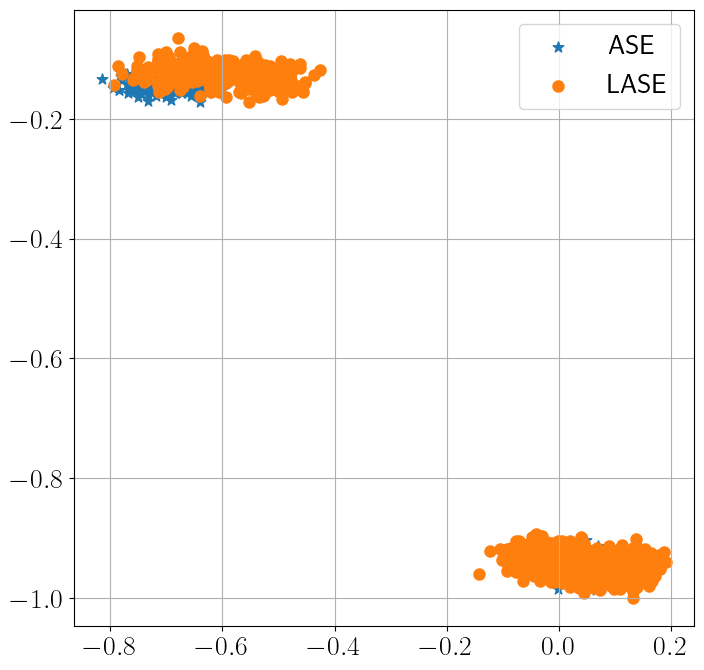

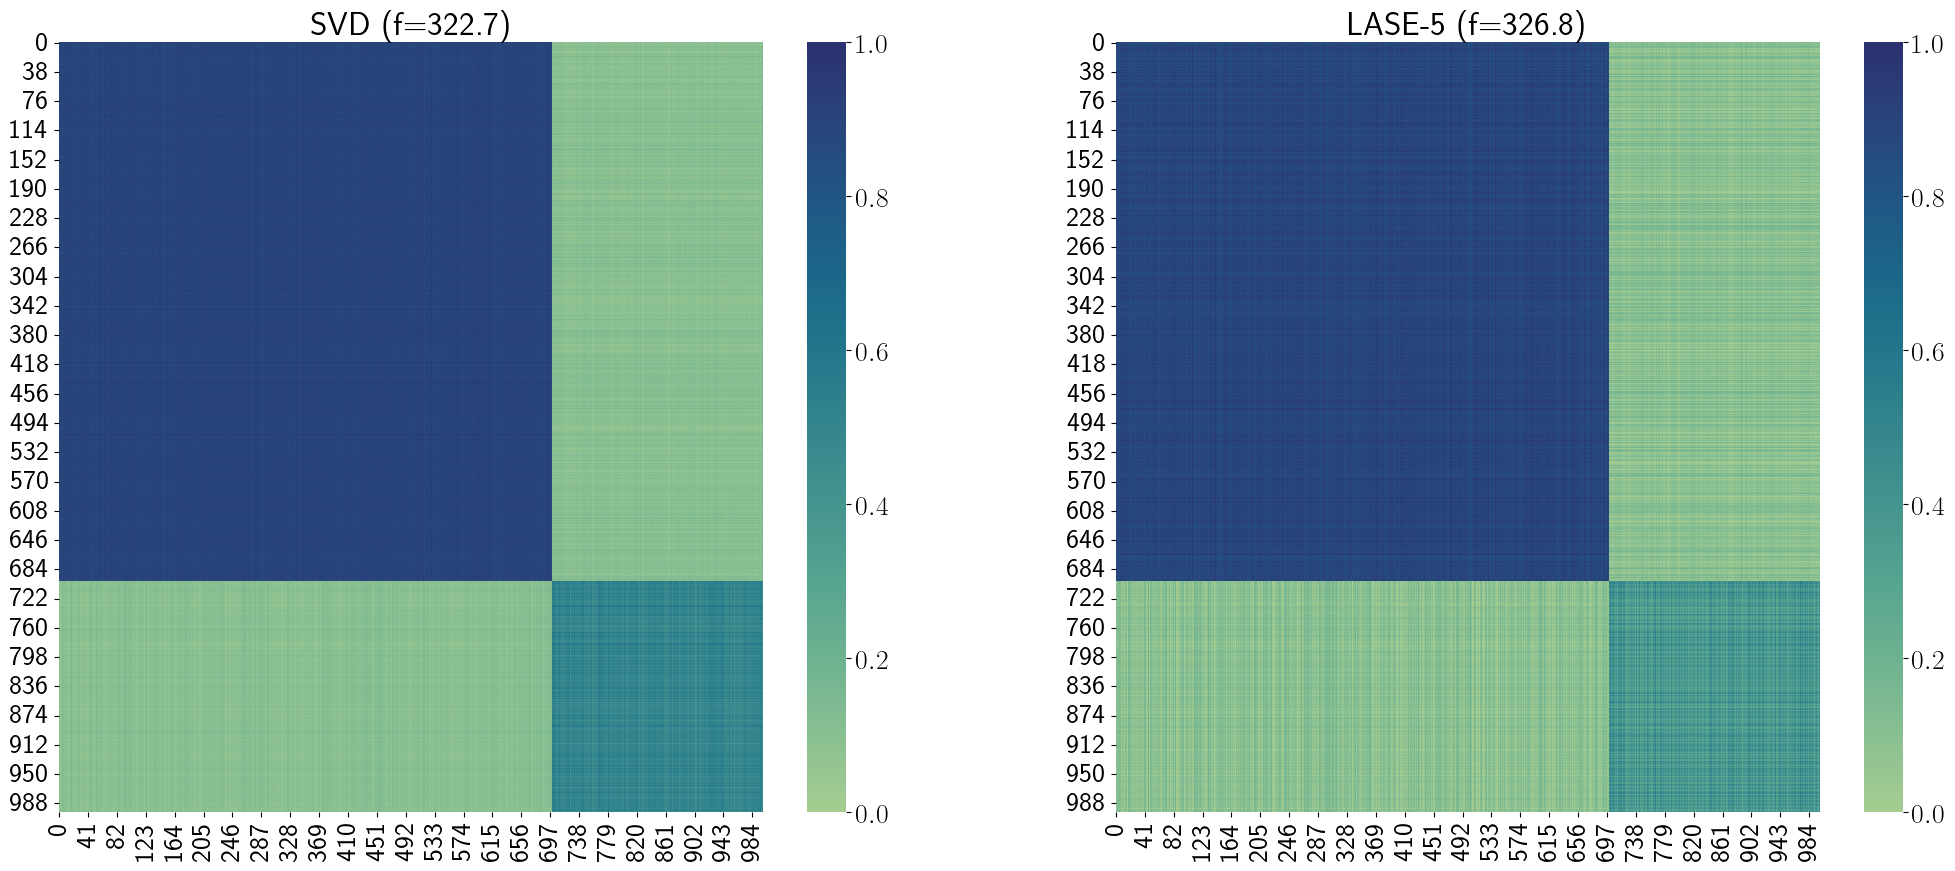

In [4]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['lines.markersize'] = 8

x_lase_p = align_Xs(x_lase,x_svd)

plt.figure(figsize=(8,8))
plt.scatter(x_svd[:,0], x_svd[:,1], label='ASE', marker='*')
plt.scatter(x_lase_p[:,0], x_lase_p[:,1], label='LASE', marker='o')
plt.legend()
plt.grid()
plt.show()


fig, axes = plt.subplots(1, 2, figsize =(25,10))
axes[0].set_title(f'SVD (f={loss_svd:.1f})')
sns.heatmap(x_svd@x_svd.T, ax=axes[0], vmin=0.0, vmax=1.0, cbar=True, cmap="crest")
axes[1].set_title(f'LASE-{gd_steps} (f={loss_lase:.1f})')
sns.heatmap(x_lase@x_lase.T, ax=axes[1], vmin=0.0, vmax=1.0, cbar=True, cmap="crest")
plt.show()


## SBM-2 v2

In [5]:
edge_index = stochastic_blockmodel_graph(n2, p2).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)
x = torch.rand((num_nodes, d)).to(device)

x_lase = lase(x, edge_index, edge_index_2, mask)
x_lase = x_lase.detach()
loss_lase = torch.norm((x_lase@x_lase.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers): ", loss_lase)
x_lase = x_lase.to('cpu')

x_svd = embed_scipy(edge_index,d)
loss_svd = np.linalg.norm((x_svd@x_svd.T - to_dense_adj(edge_index).squeeze(0).numpy())*to_dense_adj(mask).squeeze(0))
print("Loss RDPG SVD Truncate: ", loss_svd)


Loss LASE shared weights (5 layers):  tensor(405.9999)
Loss RDPG SVD Truncate:  402.32187


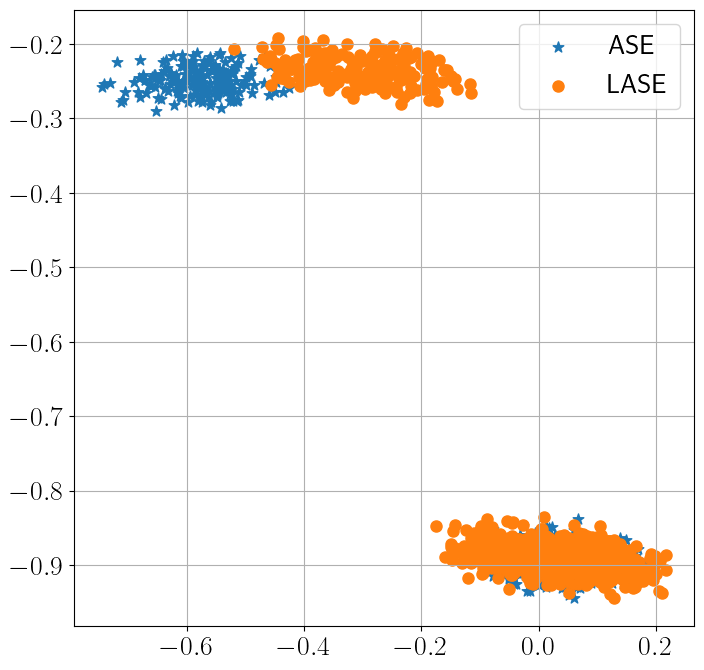

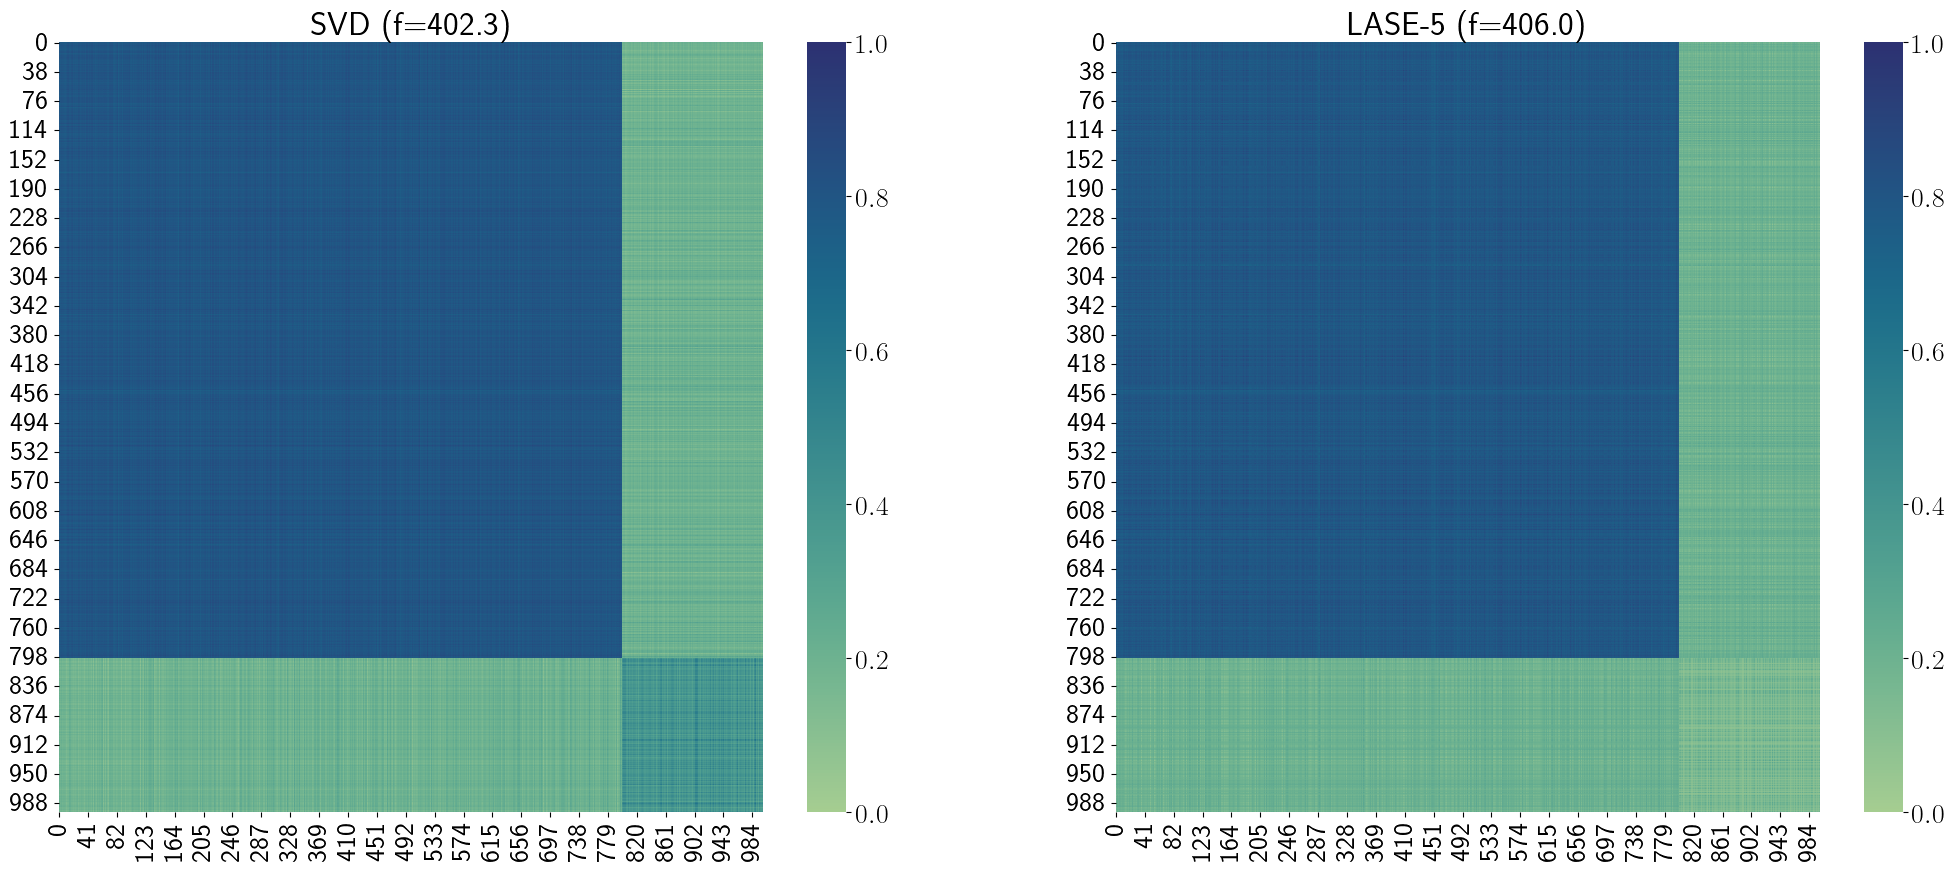

In [6]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['lines.markersize'] = 8

x_lase_p = align_Xs(x_lase,x_svd)

plt.figure(figsize=(8,8))
plt.scatter(x_svd[:,0], x_svd[:,1], label='ASE', marker='*')
plt.scatter(x_lase_p[:,0], x_lase_p[:,1], label='LASE', marker='o')
plt.legend()
plt.grid()
plt.show()


fig, axes = plt.subplots(1, 2, figsize =(25,10))
axes[0].set_title(f'SVD (f={loss_svd:.1f})')
sns.heatmap(x_svd@x_svd.T, ax=axes[0], vmin=0.0, vmax=1.0, cbar=True, cmap="crest")
axes[1].set_title(f'LASE-{gd_steps} (f={loss_lase:.1f})')
sns.heatmap(x_lase@x_lase.T, ax=axes[1], vmin=0.0, vmax=1.0, cbar=True, cmap="crest")
plt.show()

## SBM-2 v3

In [7]:
edge_index = stochastic_blockmodel_graph(n3, p3).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)
x = torch.rand((num_nodes, d)).to(device)

x_lase = lase(x, edge_index, edge_index_2, mask)
x_lase = x_lase.detach()
loss_lase = torch.norm((x_lase@x_lase.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers): ", loss_lase)
x_lase = x_lase.to('cpu')

x_svd = embed_scipy(edge_index,d)
loss_svd = np.linalg.norm((x_svd@x_svd.T - to_dense_adj(edge_index).squeeze(0).numpy())*to_dense_adj(mask).squeeze(0))
print("Loss RDPG SVD Truncate: ", loss_svd)

Loss LASE shared weights (5 layers):  tensor(410.6616)
Loss RDPG SVD Truncate:  364.7706


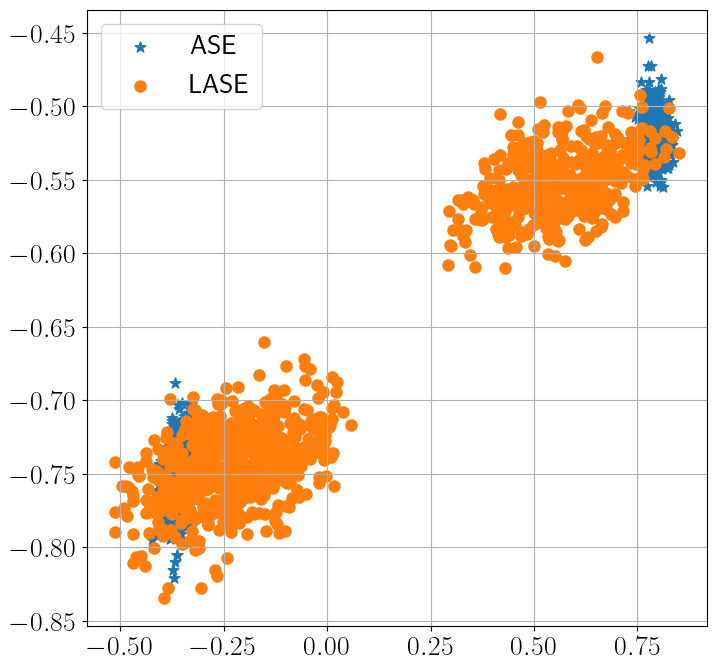

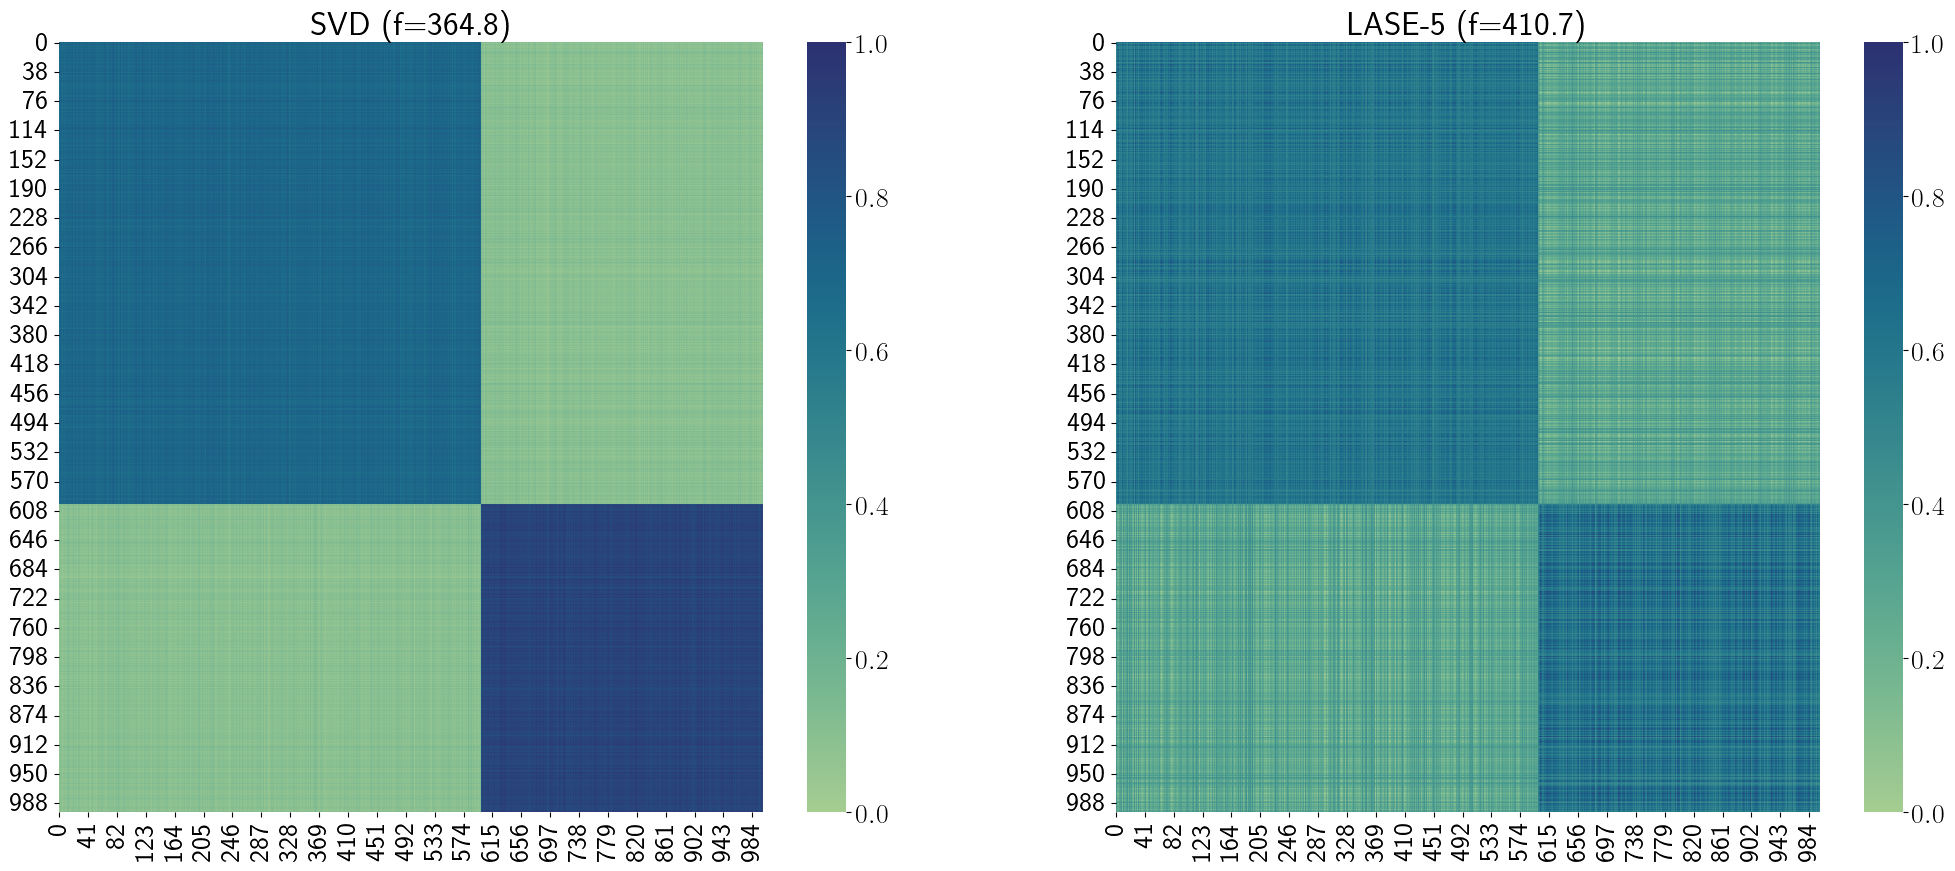

In [8]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['lines.markersize'] = 8

x_lase_p = align_Xs(x_lase,x_svd)

plt.figure(figsize=(8,8))
plt.scatter(x_svd[:,0], x_svd[:,1], label='ASE', marker='*')
plt.scatter(x_lase_p[:,0], x_lase_p[:,1], label='LASE', marker='o')
plt.legend()
plt.grid()
plt.show()


fig, axes = plt.subplots(1, 2, figsize =(25,10))
axes[0].set_title(f'SVD (f={loss_svd:.1f})')
sns.heatmap(x_svd@x_svd.T, ax=axes[0], vmin=0.0, vmax=1.0, cbar=True, cmap="crest")
axes[1].set_title(f'LASE-{gd_steps} (f={loss_lase:.1f})')
sns.heatmap(x_lase@x_lase.T, ax=axes[1], vmin=0.0, vmax=1.0, cbar=True, cmap="crest")
plt.show()


## SBM-2 v4

In [9]:
edge_index = stochastic_blockmodel_graph(n4, p4).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)
x = torch.rand((num_nodes, d)).to(device)

x_lase = lase(x, edge_index, edge_index_2, mask)
x_lase = x_lase.detach()
loss_lase = torch.norm((x_lase@x_lase.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers): ", loss_lase)
x_lase = x_lase.to('cpu')

x_svd = embed_scipy(edge_index,d)
loss_svd = np.linalg.norm((x_svd@x_svd.T - to_dense_adj(edge_index).squeeze(0).numpy())*to_dense_adj(mask).squeeze(0))
print("Loss RDPG SVD Truncate: ", loss_svd)

Loss LASE shared weights (5 layers):  tensor(469.7126)
Loss RDPG SVD Truncate:  367.09094


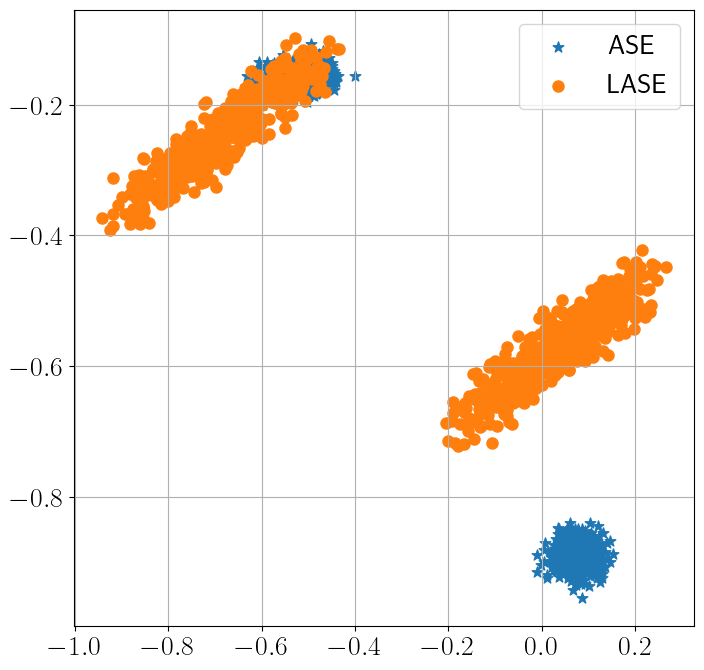

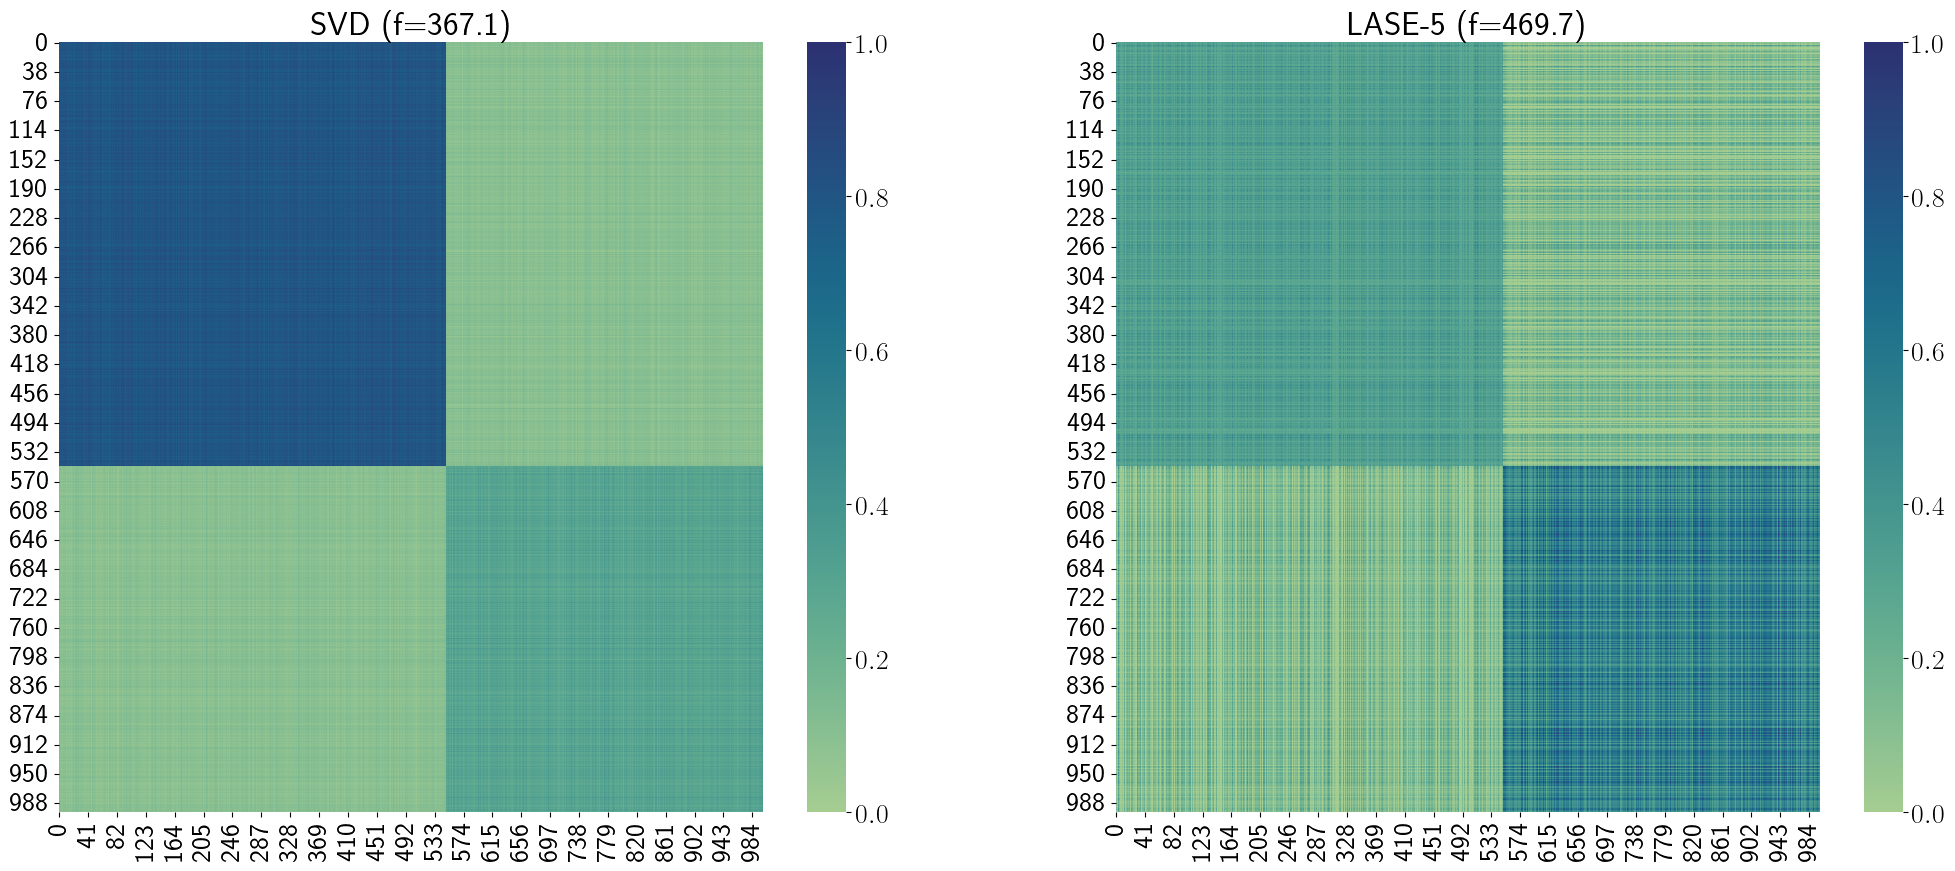

In [10]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['lines.markersize'] = 8

x_lase_p = align_Xs(x_lase,x_svd)

plt.figure(figsize=(8,8))
plt.scatter(x_svd[:,0], x_svd[:,1], label='ASE', marker='*')
plt.scatter(x_lase_p[:,0], x_lase_p[:,1], label='LASE', marker='o')
plt.legend()
plt.grid()
plt.show()


fig, axes = plt.subplots(1, 2, figsize =(25,10))
axes[0].set_title(f'SVD (f={loss_svd:.1f})')
sns.heatmap(x_svd@x_svd.T, ax=axes[0], vmin=0.0, vmax=1.0, cbar=True, cmap="crest")
axes[1].set_title(f'LASE-{gd_steps} (f={loss_lase:.1f})')
sns.heatmap(x_lase@x_lase.T, ax=axes[1], vmin=0.0, vmax=1.0, cbar=True, cmap="crest")
plt.show()


# LASE SBM-2

In [3]:
gd_steps = 5
device = 'cpu'
num_nodes = 1000

dataset = 'sbm2_unbalanced_positive'

d = config[dataset]['d']
p = config[dataset]['p']
n = np.array(config[dataset]['n'])*10

print(p)
print(n)
num_nodes = np.sum(n)

lase = LASE(d, d, gd_steps)
lase.load_state_dict(torch.load(f'../saved_models/lase_{dataset}_d{d}_normalized_random_{gd_steps}steps_FULL.pt'))

lase.to(device)
lase.eval()


## ORIGINAL DIST.

edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)
x = torch.rand((num_nodes, d)).to(device)

x_lase_0 = lase(x, edge_index, edge_index_2, mask)
x_lase_0 = x_lase_0.detach()
loss_lase_0 = torch.norm((x_lase_0@x_lase_0.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers): ", loss_lase_0)
x_lase_0 = x_lase_0.to('cpu')

x_svd_0 = embed_scipy(edge_index,d)
loss_svd_0 = np.linalg.norm((x_svd_0@x_svd_0.T - to_dense_adj(edge_index).squeeze(0).numpy())*to_dense_adj(mask).squeeze(0))
print("Loss RDPG SVD Truncate: ", loss_svd_0)

[[0.9, 0.1], [0.1, 0.5]]
[700 300]
Loss LASE shared weights (5 layers):  tensor(322.6168)
Loss RDPG SVD Truncate:  322.5616


In [4]:
p2 = config['sbm2_unbalanced_positive_2']['p']
n2 = np.array(config['sbm2_unbalanced_positive_2']['n'])*10

delta = 0.05
p2 = np.array(p) + delta 
# p2 = [[0.95, 0.15], [0.15, 0.55]]
# n2 = [705, 295]
n2 = n

print(p2)
print(n2)
edge_index = stochastic_blockmodel_graph(n2, p2).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)
# x = torch.rand((num_nodes, d)).to(device)

x_lase_1 = lase(x, edge_index, edge_index_2, mask)
x_lase_1 = x_lase_1.detach()
loss_lase_1 = torch.norm((x_lase_1@x_lase_1.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask).squeeze(0))
print(f"Loss LASE shared weights ({gd_steps} layers): ", loss_lase_1)
x_lase_1 = x_lase_1.to('cpu')

x_svd_1 = embed_scipy(edge_index,d)
loss_svd_1 = np.linalg.norm((x_svd_1@x_svd_1.T - to_dense_adj(edge_index).squeeze(0).numpy())*to_dense_adj(mask).squeeze(0))
print("Loss RDPG SVD Truncate: ", loss_svd_1)


deltas = np.linspace(-0.09, 0.09, 21)
lase_loss_array = []
svd_loss_array = []

edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)

for delta in deltas:
    # SETUP GRAPH
    p2 = p2 = np.array(p) + delta 
    n2 = n

    edge_index = stochastic_blockmodel_graph(n2, p2).to(device)

    # LASE
    x_lase_ = lase(x, edge_index, edge_index_2, mask)
    x_lase_ = x_lase_.detach()
    loss_lase_1 = torch.norm((x_lase_@x_lase_.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask).squeeze(0))
    lase_loss_array.append(loss_lase_1)

    # ASE
    x_svd_ = embed_scipy(edge_index,d)
    loss_svd_1 = np.linalg.norm((x_svd_@x_svd_.T - to_dense_adj(edge_index).squeeze(0).numpy())*to_dense_adj(mask).squeeze(0))
    svd_loss_array.append(loss_svd_1)

[[0.95 0.15]
 [0.15 0.55]]
[700 300]
Loss LASE shared weights (5 layers):  tensor(336.1833)
Loss RDPG SVD Truncate:  313.91852


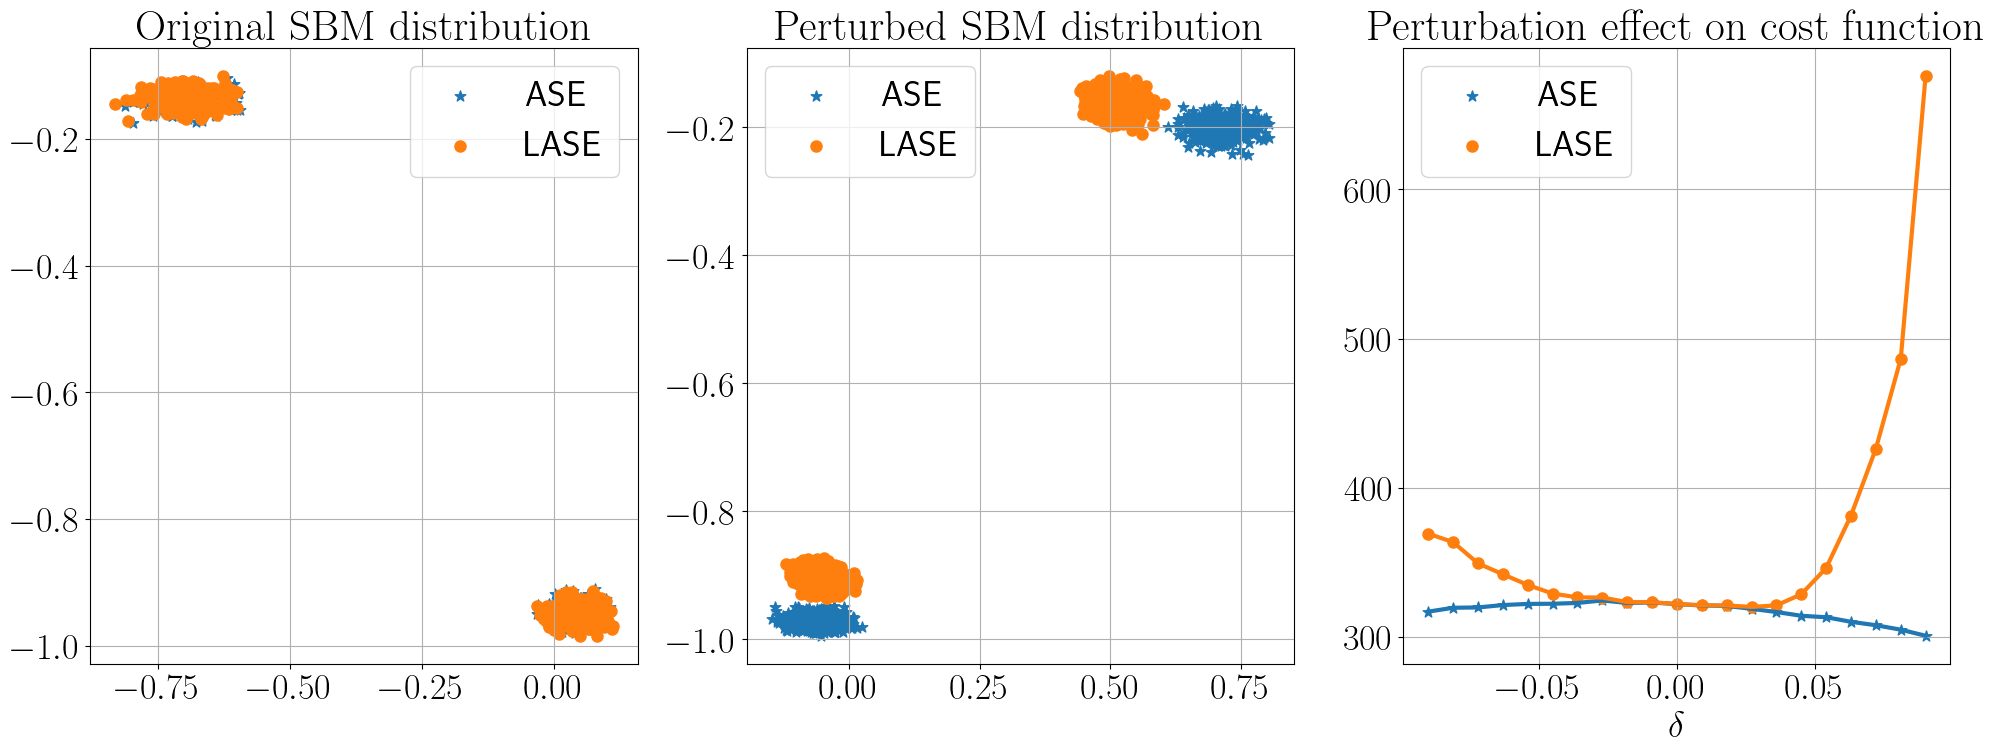

In [5]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 26
plt.rcParams['lines.markersize'] = 8


x_lase_p0 = align_Xs(x_lase_0,x_svd_0)
x_lase_p1 = align_Xs(x_lase_1,x_svd_1)

fig, axes = plt.subplots(1, 3, figsize=(24,8))
axes[0].set_title(r'$\mathrm{Original \ SBM \ distribution}$')
axes[0].scatter(x_svd_0[:,0], x_svd_0[:,1], label='ASE', marker='*')
axes[0].scatter(x_lase_p0[:,0], x_lase_p0[:,1], label='LASE', marker='o')
axes[1].set_title(r'$\mathrm{Perturbed \ SBM \ distribution}$')
axes[1].scatter(x_svd_1[:,0], x_svd_1[:,1], label='ASE', marker='*')
axes[1].scatter(x_lase_p1[:,0], x_lase_p1[:,1], label='LASE', marker='o')
axes[2].set_title(r'$\mathrm{Perturbation \ effect \ on \ cost \ function}$')
axes[2].scatter(deltas, svd_loss_array, label='ASE', marker='*')
axes[2].scatter(deltas, lase_loss_array, label='LASE', marker='o')
axes[2].plot(deltas, svd_loss_array)
axes[2].plot(deltas, lase_loss_array)
# axes[2].set_ylabel(r'$f$')
axes[2].set_xlabel(r'$\mathrm{\delta}$')
axes[0].legend()
axes[0].grid()
axes[1].legend()
axes[1].grid()
axes[2].grid()
axes[2].legend()
# fig.savefig("./paper/perturbation_sbm2.pdf")
plt.show()

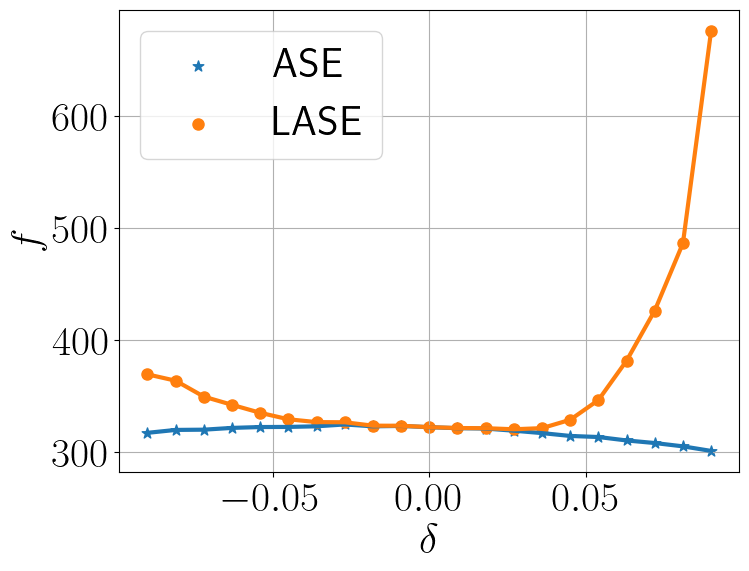

In [6]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 30
plt.rcParams['lines.markersize'] = 8

plt.figure(figsize=(8,6))
plt.scatter(deltas, svd_loss_array, label='ASE', marker='*')
plt.scatter(deltas, lase_loss_array, label='LASE', marker='o')
plt.plot(deltas, svd_loss_array)
plt.plot(deltas, lase_loss_array)
plt.ylabel(r'$f$')
plt.xlabel(r'$\mathrm{\delta}$')
plt.grid()
plt.legend()
plt.show()

## Training for mixed dataset

In [7]:
gd_steps = 5
device = 'cpu'
num_nodes = 1000

dataset = 'sbm2_unbalanced_positive_mixed_2'

d = config[dataset]['d']
p = config[dataset]['p']
n = np.array(config[dataset]['n'])*10

print(p)
print(n)
num_nodes = np.sum(n)


print(f'../saved_models/lase_{dataset}_d{d}_normalized_random_{gd_steps}steps_FULL.pt')
lase = LASE(d, d, gd_steps)
lase.load_state_dict(torch.load(f'../saved_models/lase_{dataset}_d{d}_normalized_random_{gd_steps}steps_FULL_.pt'))
lase.to(device)
lase.eval()

deltas = np.linspace(-0.09, 0.09, 21)
lase_loss_array_2 = []
svd_loss_array_2 = []

edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)

for delta in deltas:
    # SETUP GRAPH
    p2 = np.array(p) + delta 

    edge_index = stochastic_blockmodel_graph(n, p2).to(device)

    # LASE
    x_lase_ = lase(x, edge_index, edge_index_2, mask)
    x_lase_ = x_lase_.detach()
    loss_lase_1 = torch.norm((x_lase_@x_lase_.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask).squeeze(0))
    lase_loss_array_2.append(loss_lase_1)

    # ASE
    x_svd_ = embed_scipy(edge_index,d)
    loss_svd_1 = np.linalg.norm((x_svd_@x_svd_.T - to_dense_adj(edge_index).squeeze(0).numpy())*to_dense_adj(mask).squeeze(0))
    svd_loss_array_2.append(loss_svd_1)


[[0.9, 0.1], [0.1, 0.5]]
[700 300]
../saved_models/lase_sbm2_unbalanced_positive_mixed_2_d2_normalized_random_5steps_FULL.pt


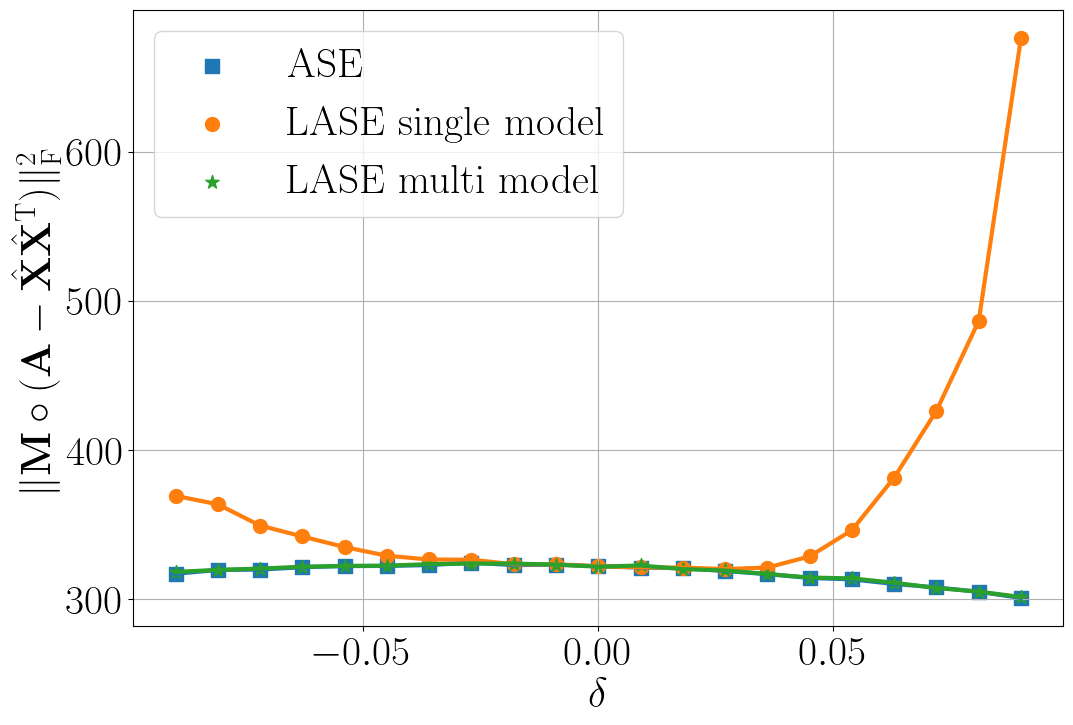

In [32]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 30
plt.rcParams['lines.markersize'] = 10

fig = plt.figure(figsize=(12,8))
# plt.title(r'$\mathrm{Perturbation \ effect \ on \ cost \ function}$')
plt.scatter(deltas, svd_loss_array, label=r'$\mathrm{ASE}$', marker='s')
plt.scatter(deltas, lase_loss_array, label=r'$\mathrm{LASE \ single \ model}$', marker='o')
plt.scatter(deltas, lase_loss_array_2, label=r'$\mathrm{LASE \ multi \ model}$', marker='*')
plt.plot(deltas, svd_loss_array)
plt.plot(deltas, lase_loss_array)
plt.plot(deltas, lase_loss_array_2)
plt.xlabel(r'$\mathrm{\delta}$')
plt.ylabel(r'$\mathrm{\|\mathbf M\circ(\mathbf A - \hat \mathbf X\hat \mathbf X^T)\|^2_F}$')
# plt.ylabel(r'$\|\mathbf M\circ(\mathbf A- \hbX \mathbf Q \mathbf \hbX^\top)\|^2_F$')
plt.grid()
plt.legend()
fig.savefig("./paper/perturbation_sbm2.pdf")
plt.show()

In [143]:
deltas

array([-0.09 , -0.081, -0.072, -0.063, -0.054, -0.045, -0.036, -0.027,
       -0.018, -0.009,  0.   ,  0.009,  0.018,  0.027,  0.036,  0.045,
        0.054,  0.063,  0.072,  0.081,  0.09 ])

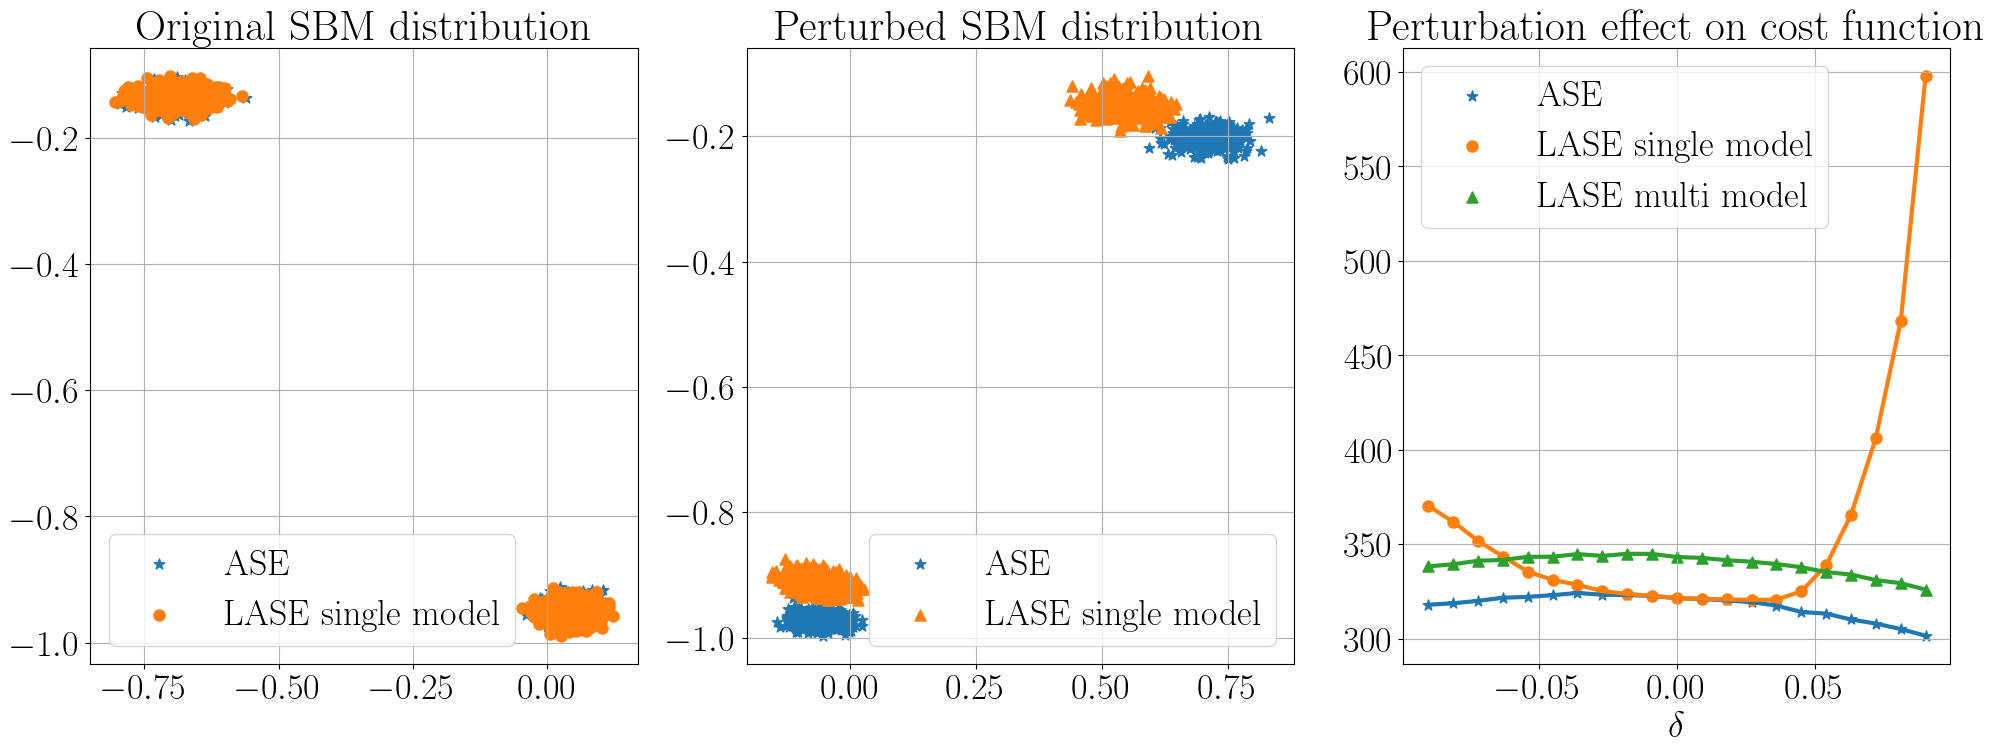

In [ ]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 26
plt.rcParams['lines.markersize'] = 8


x_lase_p0 = align_Xs(x_lase_0,x_svd_0)
x_lase_p1 = align_Xs(x_lase_1,x_svd_1)

fig, axes = plt.subplots(1, 3, figsize=(24,8))
axes[0].set_title(r'$\mathrm{Original \ SBM \ distribution}$')
axes[0].scatter(x_svd_0[:,0], x_svd_0[:,1], label=r'$\mathrm{ASE}$', marker='*')
axes[0].scatter(x_lase_p0[:,0], x_lase_p0[:,1], label=r'$\mathrm{LASE \ single \ model}$', marker='o')
axes[1].set_title(r'$\mathrm{Perturbed \ SBM \ distribution}$')
axes[1].scatter(x_svd_1[:,0], x_svd_1[:,1], label=r'$\mathrm{ASE}$', marker='*')
axes[1].scatter(x_lase_p1[:,0], x_lase_p1[:,1], label=r'$\mathrm{LASE \ single \ model}$', marker='^')
axes[2].set_title(r'$\mathrm{Perturbation \ effect \ on \ cost \ function}$')
axes[2].scatter(deltas, svd_loss_array, label=r'$\mathrm{ASE}$', marker='*')
axes[2].scatter(deltas, lase_loss_array, label=r'$\mathrm{LASE \ single \ model}$', marker='o')
axes[2].scatter(deltas, lase_loss_array_2, label=r'$\mathrm{LASE \ multi \ model}$', marker='^')
axes[2].plot(deltas, svd_loss_array)
axes[2].plot(deltas, lase_loss_array)
axes[2].plot(deltas, lase_loss_array_2)
axes[2].set_ylabel(r'$f$')
axes[2].set_xlabel(r'$\mathrm{\delta}$')
axes[0].legend()
axes[0].grid()
axes[1].legend()
axes[1].grid()
axes[2].grid()
axes[2].legend()
fig.savefig("./paper/perturbation_sbm2.pdf")
plt.show()